<h1 style="text-align: center">
 </br> 
Image Classification
</h1>

## Import needed libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

In [6]:
transform = transforms.ToTensor()
train_set = torchvision.datasets.FashionMNIST(root='Desktop', train=True,download=True, transform=transform)
test_set = torchvision.datasets.FashionMNIST(root='Desktop', train=False,download=True, transform=transform)


In [16]:
# split training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds,val_ds = random_split(train_set, [train_size, val_size])


In [17]:
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary
#my first choisce is batchsize=64
train_dataloader = DataLoader(train_ds,batch_size=64,shuffle=True,)
val_dataloader = DataLoader(val_ds,batch_size=64,shuffle=True)
test_dataloader = DataLoader(test_set,batch_size=64,shuffle=True)
classes = train_set.classes


**Display some images from dataset**

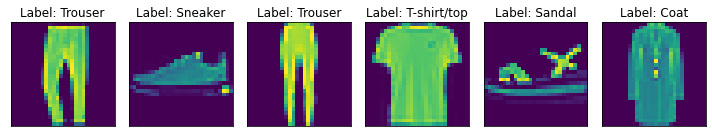

In [18]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [206]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),                            
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
        nn.Linear(in_features=64 * 6 * 6 , out_features=600),
        nn.Linear(in_features=600, out_features=120),
        nn.Linear(in_features=120, out_features=10),
        )

        
        
    def forward(self, x):

        
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1,64 * 6 * 6)
        out = self.layer3(x)


        
        return out
    


In [207]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [208]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): Linear(in_features=600, out_features=120, bias=True)
    (2): Linear(in_features=120, out_features=10, bias=True)
  )
)

In [209]:
import torch.optim as optim

Learning_rate= 1e-3
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(),lr=Learning_rate)


In [210]:
epochs = 10
save_path="/content/cnn_model"

In [211]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [212]:
# training loop
def train_model(model, train_dataloader, val_dataloader, n_epochs, optimizer, criterion, device, save_path):
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
        model.train()  
        epoch_loss = 0  
        with tqdm(train_dataloader, unit="batch") as batches:
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")
                
                # move to GPU
                data, target = data.to(device), target.to(device)

                # train 
                optimizer.zero_grad()

                outputs = model(data)

                loss = criterion(outputs, target)
                epoch_loss += loss.item()

                loss.backward()

                optimizer.step()

                acc = multi_acc(outputs, target)
                batches.set_postfix(train_loss=loss.item(), train_accuracy=acc.item())
        train_losses.append(epoch_loss / len(train_dataloader))

        ####### Validation Phase ########
        model.eval() 
        val_loss = 0  
        with torch.no_grad():
            y_true, y_pred = [], []
            for data, target in val_dataloader:
                # move data and target tensors to the device
                data, target = data.to(device), target.to(device)

                outputs = model(data)

                loss = criterion(outputs, target)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_dataloader))

        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, val_loss / len(val_dataloader)))
        if val_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_min,
                val_loss / len(val_dataloader)))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = val_loss

    return model, train_losses, val_losses

**Train the model**

In [214]:
model, train_losses, val_losses = train_model(cnn_model, train_dataloader, val_dataloader, epochs, optimizer, criterion, device, save_path)


Epoch 1: 100%|███████████████████████████████| 750/750 [00:55<00:00, 13.55batch/s, train_accuracy=89, train_loss=0.287]


Epoch: 1  Validation Loss: 0.333957
Validation loss decreased (inf --> 0.333957).  Saving model ...


Epoch 2: 100%|███████████████████████████████| 750/750 [00:55<00:00, 13.60batch/s, train_accuracy=97, train_loss=0.156]


Epoch: 2  Validation Loss: 0.296431
Validation loss decreased (62.783914 --> 0.296431).  Saving model ...


Epoch 3: 100%|███████████████████████████████| 750/750 [00:55<00:00, 13.48batch/s, train_accuracy=98, train_loss=0.124]


Epoch: 3  Validation Loss: 0.276751
Validation loss decreased (55.728942 --> 0.276751).  Saving model ...


Epoch 4: 100%|███████████████████████████████| 750/750 [00:53<00:00, 14.12batch/s, train_accuracy=92, train_loss=0.181]


Epoch: 4  Validation Loss: 0.259475
Validation loss decreased (52.029254 --> 0.259475).  Saving model ...


Epoch 5: 100%|████████████████████████████████| 750/750 [00:53<00:00, 14.02batch/s, train_accuracy=89, train_loss=0.32]


Epoch: 5  Validation Loss: 0.296700


Epoch 6: 100%|███████████████████████████████| 750/750 [00:53<00:00, 13.95batch/s, train_accuracy=94, train_loss=0.188]


Epoch: 6  Validation Loss: 0.259727


Epoch 7: 100%|███████████████████████████████| 750/750 [00:53<00:00, 13.95batch/s, train_accuracy=97, train_loss=0.114]


Epoch: 7  Validation Loss: 0.294421


Epoch 8: 100%|███████████████████████████████| 750/750 [00:52<00:00, 14.17batch/s, train_accuracy=95, train_loss=0.154]


Epoch: 8  Validation Loss: 0.266327


Epoch 9: 100%|███████████████████████████████| 750/750 [00:52<00:00, 14.15batch/s, train_accuracy=89, train_loss=0.277]


Epoch: 9  Validation Loss: 0.285278


Epoch 10: 100%|█████████████████████████████| 750/750 [00:52<00:00, 14.22batch/s, train_accuracy=97, train_loss=0.0922]


Epoch: 10  Validation Loss: 0.273575


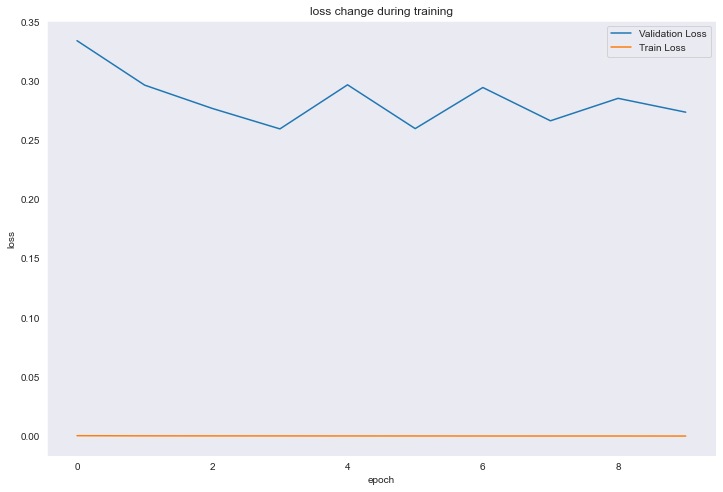

In [215]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses)/1000,label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [241]:
def predict(images, model):
    predicted = torch.max(model(images),dim=1)[1] 
    return predicted

**Accuracy Result on Test Data**

In [244]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        predicted = predict(images, model)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  
        for  x in predicted.cpu().numpy(): y_pred_list.append(x)
        for  x in labels.cpu().numpy(): y_true_list.append(x)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 90 %


**Classification report**

In [245]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.94      0.73      0.82      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.88      0.85      0.87      1000
       Dress       0.87      0.95      0.91      1000
        Coat       0.86      0.86      0.86      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.68      0.82      0.75      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       1.00      0.97      0.98      1000
  Ankle boot       0.97      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



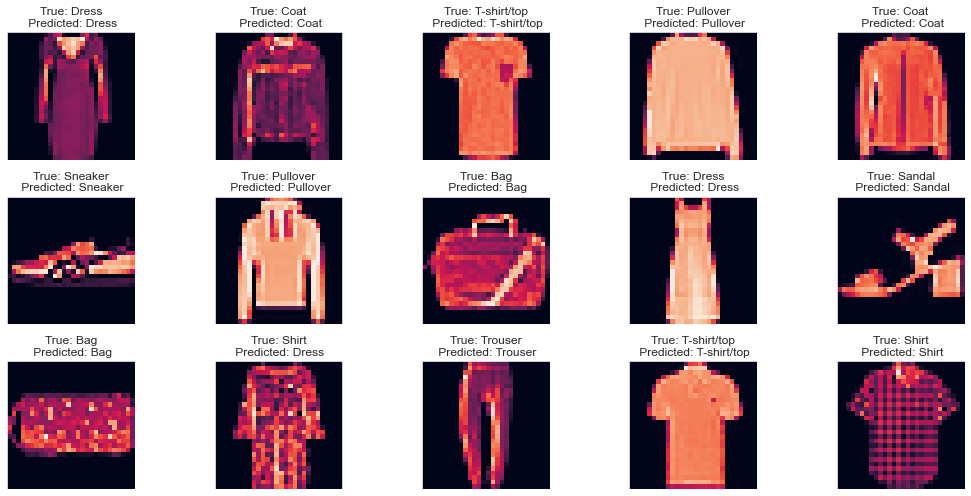

In [248]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images,cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()